# [1D-BASELINE] Exp1: Robot Baseline LEFT

## Import

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
import datetime
import time
from IPython.display import clear_output

In [4]:
from grace.system import Grace
from grace.capture import LeftEyeCapture, RightEyeCapture
from grace.utils import get_center_chessboard_point, generate_triangle_wave

## Initialization

In [5]:
# Instantiation
grace = Grace(degrees=True)
left_cam = LeftEyeCapture()

[ROS Client] ROS Connection Successful at http://BodyNC-NUC:9090


In [39]:
# Experiment Helper Functions

def px_to_deg_fx(x):
    x = math.atan(x/569.4456315)  #LEFT: fx = 569.4456315. fy = 571.54490033
    x = math.degrees(x)
    return x

def save_pickle_data(data, camera: str, name: str):
    # Making Directory
    filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f") + "_" + camera + "_" + name
    filepath = os.path.join(os.path.abspath(".."), "const_results", filename)

    # Saving to Pickle File
    with open(filepath + ".pickle", 'wb') as file:
        pickle.dump(data, file)
    print('Data saved in:', filepath + ".pickle")
    return filepath + ".pickle"

def slow_reset():
    grace.slow_move_left_eye_pan(angle=-8, step_size=0.0879, time_interval=0.015)
    grace.slow_centering_eyes()
    
def generate_graphs(data, tilt, x_org):
    tilt_idx = tilt_arr.index(tilt)
    
    # Input Array
    plt.figure()
    input_arr  = data["input_arr"]
    plt.plot(input_arr)
    plt.ylim([-20, 20])
    plt.xlabel('Samples')
    plt.ylabel('Input Angle (deg)')
    plt.title('Input Motor Command')
    
    # Pixel vs Input Array (Raw)
    raw_x_pixel_arr = [x[0] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, raw_x_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Pixel X Value')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Pixel vs Input Array (Raw)
    x_pixel_arr = [x_org-x[0] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, x_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Delta Pixel X Value (wrt 320 px)')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Time Series Eye Output vs Input Array
    phi = [px_to_deg_fx(x_org-x[0]) for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr)
    plt.plot(phi, color='orange')
    plt.xlabel('Samples')
    plt.ylabel('Angles (deg)')
    plt.ylim([-20, 20])
    plt.legend(['Input Command', 'Eye Output'])
    plt.title('Theta vs Phi')

    # Eye Output vs Input Array
    plt.figure()
    plt.plot(input_arr, phi, color="orange")
    plt.xlabel('Input Command')
    plt.ylabel('Eye Output')
    plt.title('Robot Data')
    plt.grid() 
    

In [7]:
# Initialization

pickle_data = {
    "title": "[1D-BASELINE] Exp1: Robot Baseline",
    "description": None,
    "data_label": [16, 8, 4, 2],
    "data": None,
    "datetime": datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
}

data_list = []

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep
    "input_cmd": [],  # Data points or Triangle Wave
    "pixel_data": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

In [8]:
# Center the left eye

grace.slow_centering_eyes()

(0.0, 0.0)

## EXP1.1. 11 Degrees Amplitude

In [9]:
# Parameters

init_amp = 0
min_amp = -11
max_amp = 12
step_size = 0.0879
num_cycles = 5
include_init = 1
time_interval = 0.015  # sec

tilt_arr = [0]

In [10]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep
    "input_arr": [],  # Data points or Triangle Wave
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[ 0.      0.0879  0.1758 ... -0.1758 -0.0879  0.    ]


Text(0, 0.5, 'Input Angle (deg)')

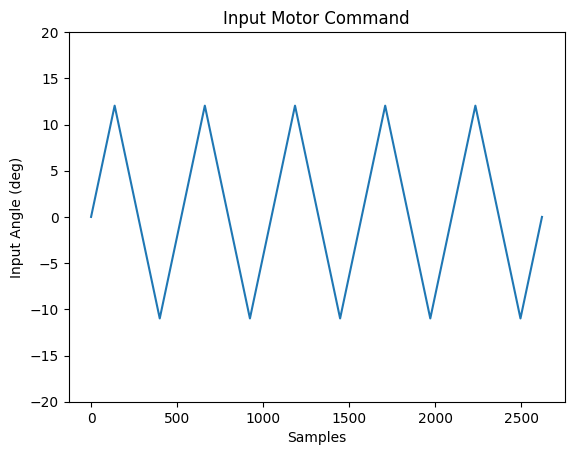

In [11]:
# Generation of triangle wave

input_arr = generate_triangle_wave(init_amp, min_amp, max_amp, step_size, num_cycles, include_init)
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr)
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [12]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr.tolist()

start = time.time()

# Initial State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

cnt = 0
for tilt in tilt_arr:
    pixel_arr = []
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)
        grace.direct_move_left_eye((pan, None))
        time.sleep(time_interval)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    data["pixel_arr"].append(pixel_arr)

# End State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame)) 
    
print("Elapsed Time:", time.time()-start)

2621/2621
pan:0.0, tilt:0
Elapsed Time: 98.76609921455383


In [13]:
# Checking of Data

data["pixel_arr"]

[[[317.5794982910156, 203.3601531982422],
  [317.5794982910156, 203.3601531982422],
  [317.5904846191406, 203.34451293945312],
  [317.5904846191406, 203.34451293945312],
  [317.57769775390625, 203.3500213623047],
  [317.57769775390625, 203.3500213623047],
  [316.7208557128906, 203.56333923339844],
  [316.7208557128906, 203.56333923339844],
  [315.1418762207031, 203.67898559570312],
  [315.1418762207031, 203.67898559570312],
  [315.1418762207031, 203.67898559570312],
  [309.75201416015625, 203.6899871826172],
  [306.3334045410156, 203.69093322753906],
  [306.3334045410156, 203.69093322753906],
  [303.4662780761719, 203.65313720703125],
  [303.4662780761719, 203.65313720703125],
  [300.5129699707031, 203.61744689941406],
  [300.5129699707031, 203.61744689941406],
  [297.27252197265625, 203.574951171875],
  [297.27252197265625, 203.574951171875],
  [297.27252197265625, 203.574951171875],
  [293.33648681640625, 203.51585388183594],
  [293.33648681640625, 203.51585388183594],
  [291.9147949

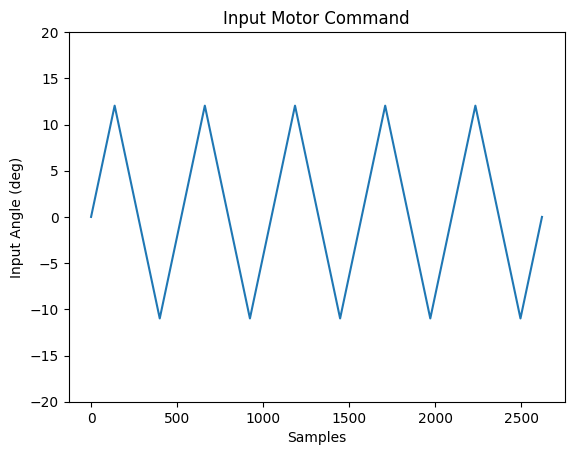

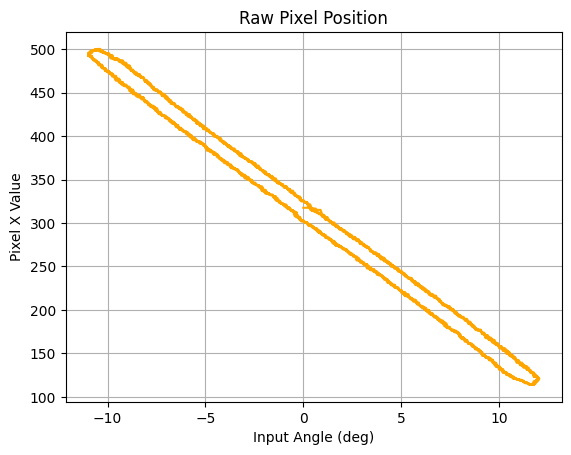

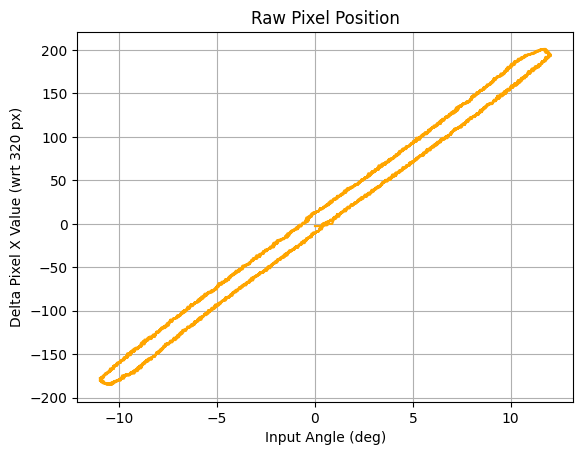

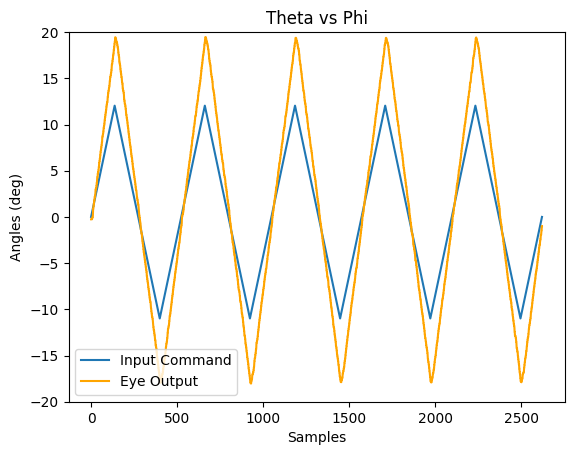

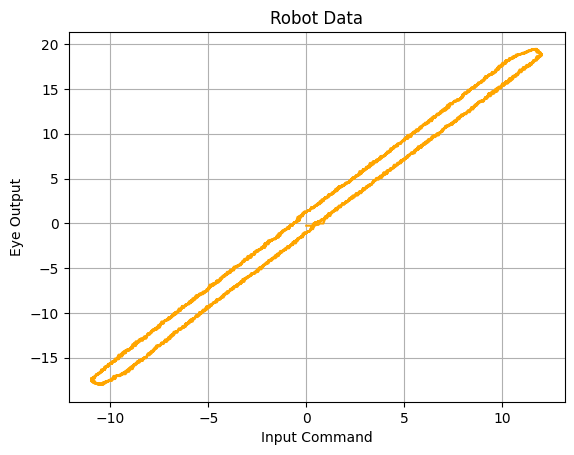

In [14]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=315)

In [15]:
# Appending to Data List

data_list.append(data)

## EXP1.2. 8 Degrees Amplitude

In [16]:
# Parameters

init_amp = 0
min_amp = -8
max_amp = 8
step_size = 0.0879
num_cycles = 5
include_init = 1
time_interval = 0.015  # sec

tilt_arr = [0]

In [17]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep
    "input_arr": [],  # Data points or Triangle Wave
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[ 0.      0.0879  0.1758 ... -0.1758 -0.0879  0.    ]


Text(0, 0.5, 'Input Angle (deg)')

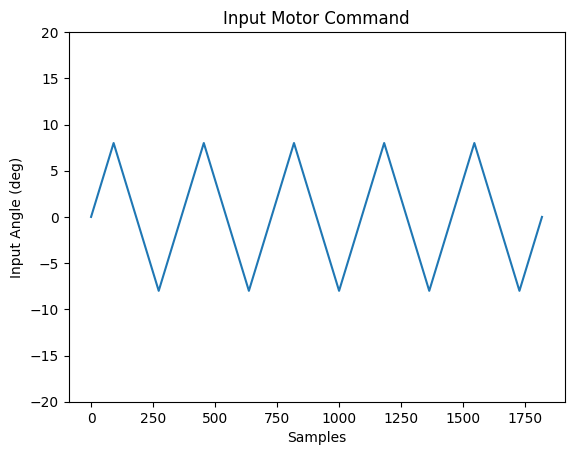

In [18]:
# Generation of triangle wave

input_arr = generate_triangle_wave(init_amp, min_amp, max_amp, step_size, num_cycles, include_init)
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr)
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [19]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr.tolist()

start = time.time()

# Initial State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

cnt = 0
for tilt in tilt_arr:
    pixel_arr = []
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)
        time.sleep(time_interval)
        grace.direct_move_left_eye((pan, None))
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    data["pixel_arr"].append(pixel_arr)

# End State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame)) 
    
print("Elapsed Time:", time.time()-start)

1821/1821
pan:0.0, tilt:0
Elapsed Time: 72.0334644317627


In [20]:
# Checking of Data

data["pixel_arr"]

[[[318.0763244628906, 203.35720825195312],
  [318.0842590332031, 203.32093811035156],
  [318.0842590332031, 203.32093811035156],
  [318.1050109863281, 203.33811950683594],
  [318.1050109863281, 203.33811950683594],
  [318.104248046875, 203.35641479492188],
  [318.104248046875, 203.35641479492188],
  [317.29693603515625, 203.5372314453125],
  [317.29693603515625, 203.5372314453125],
  [314.871337890625, 203.67091369628906],
  [314.871337890625, 203.67091369628906],
  [310.4476318359375, 203.61831665039062],
  [310.4476318359375, 203.61831665039062],
  [306.8072814941406, 203.5967559814453],
  [306.8072814941406, 203.5967559814453],
  [302.7297668457031, 203.5572967529297],
  [302.7297668457031, 203.5572967529297],
  [300.3755187988281, 203.4865264892578],
  [300.3755187988281, 203.4865264892578],
  [298.28802490234375, 203.47120666503906],
  [298.28802490234375, 203.47120666503906],
  [293.9931640625, 203.4529266357422],
  [293.9931640625, 203.4529266357422],
  [291.5935974121094, 203.3

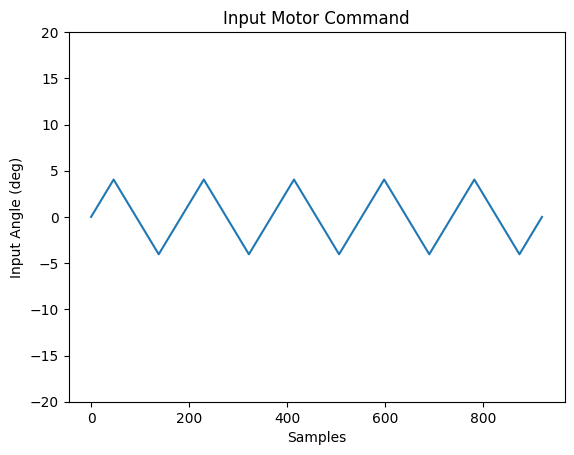

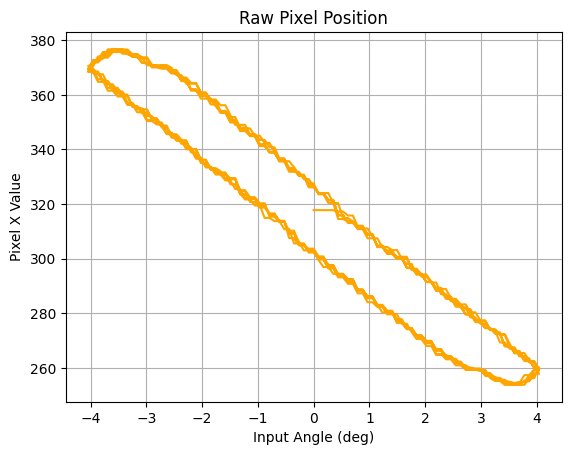

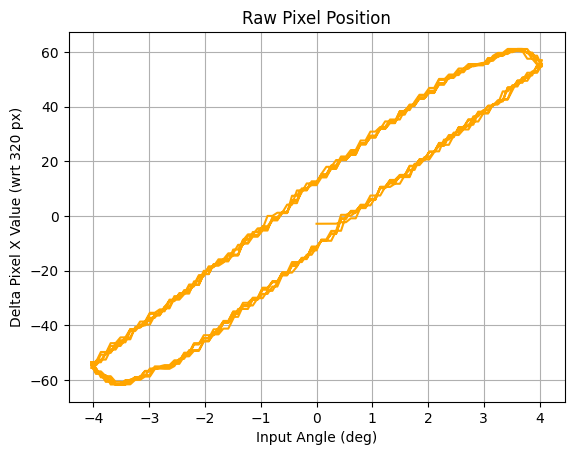

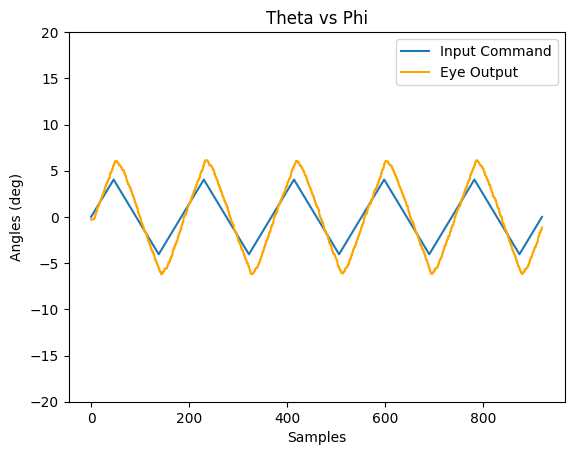

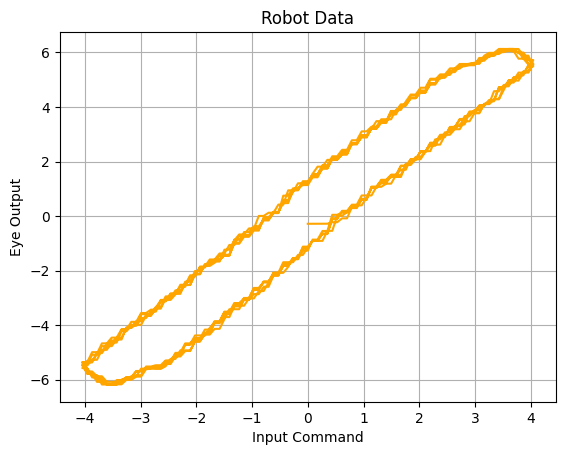

In [31]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=315)

In [22]:
# Appending to Data List

data_list.append(data)

## EXP1.3. 4 Degrees Amplitude

In [23]:
# Parameters

init_amp = 0
min_amp = -4
max_amp = 4
step_size = 0.0879
num_cycles = 5
include_init = 1
time_interval = 0.015  # sec

tilt_arr = [0]

In [24]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep
    "input_arr": [],  # Data points or Triangle Wave
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[ 0.      0.0879  0.1758  0.2637  0.3516  0.4395  0.5274  0.6153  0.7032
  0.7911  0.879   0.9669  1.0548  1.1427  1.2306  1.3185  1.4064  1.4943
  1.5822  1.6701  1.758   1.8459  1.9338  2.0217  2.1096  2.1975  2.2854
  2.3733  2.4612  2.5491  2.637   2.7249  2.8128  2.9007  2.9886  3.0765
  3.1644  3.2523  3.3402  3.4281  3.516   3.6039  3.6918  3.7797  3.8676
  3.9555  4.0434  3.9555  3.8676  3.7797  3.6918  3.6039  3.516   3.4281
  3.3402  3.2523  3.1644  3.0765  2.9886  2.9007  2.8128  2.7249  2.637
  2.5491  2.4612  2.3733  2.2854  2.1975  2.1096  2.0217  1.9338  1.8459
  1.758   1.6701  1.5822  1.4943  1.4064  1.3185  1.2306  1.1427  1.0548
  0.9669  0.879   0.7911  0.7032  0.6153  0.5274  0.4395  0.3516  0.2637
  0.1758  0.0879  0.     -0.0879 -0.1758 -0.2637 -0.3516 -0.4395 -0.5274
 -0.6153 -0.7032 -0.7911 -0.879  -0.9669 -1.0548 -1.1427 -1.2306 -1.3185
 -1.4064 -1.4943 -1.5822 -1.6701 -1.758  -1.8459 -1.9338 -2.0217 -2.1096
 -2.1975 -2.2854 -2.3733 -2.4612 -2.5491 -2.637  -2.

Text(0, 0.5, 'Input Angle (deg)')

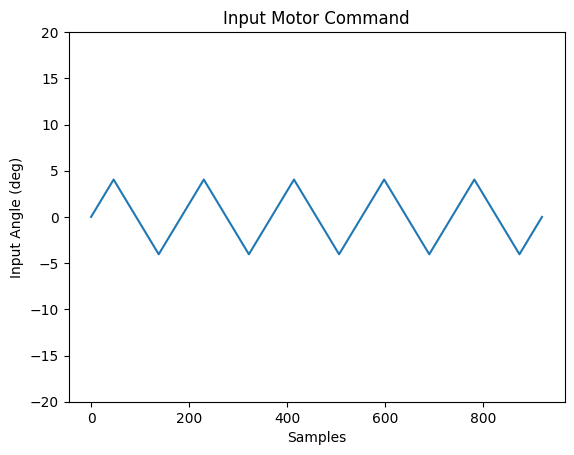

In [25]:
# Generation of triangle wave

input_arr = generate_triangle_wave(init_amp, min_amp, max_amp, step_size, num_cycles, include_init)
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr)
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [26]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr.tolist()

start = time.time()

# Initial State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

cnt = 0
for tilt in tilt_arr:
    pixel_arr = []
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)
        time.sleep(time_interval)
        grace.direct_move_left_eye((pan, None))
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    data["pixel_arr"].append(pixel_arr)

# End State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame)) 
    
print("Elapsed Time:", time.time()-start)

921/921
pan:0.0, tilt:0
Elapsed Time: 42.1269211769104


In [27]:
# Checking of Data

data["pixel_arr"]

[[[317.8096923828125, 203.34475708007812],
  [317.8096923828125, 203.34475708007812],
  [317.774658203125, 203.36837768554688],
  [317.7789001464844, 203.3563690185547],
  [317.7789001464844, 203.3563690185547],
  [317.2535705566406, 203.5069580078125],
  [317.2535705566406, 203.5069580078125],
  [315.824951171875, 203.675048828125],
  [315.824951171875, 203.675048828125],
  [311.75701904296875, 203.701171875],
  [311.75701904296875, 203.701171875],
  [308.7066345214844, 203.6540069580078],
  [308.7066345214844, 203.6540069580078],
  [304.7655334472656, 203.60110473632812],
  [304.7655334472656, 203.60110473632812],
  [303.02294921875, 203.5844268798828],
  [303.02294921875, 203.5844268798828],
  [299.971923828125, 203.5318145751953],
  [299.971923828125, 203.5318145751953],
  [296.770263671875, 203.47610473632812],
  [296.770263671875, 203.47610473632812],
  [294.4158630371094, 203.46975708007812],
  [294.4158630371094, 203.46975708007812],
  [291.5180969238281, 203.4213104248047],
  

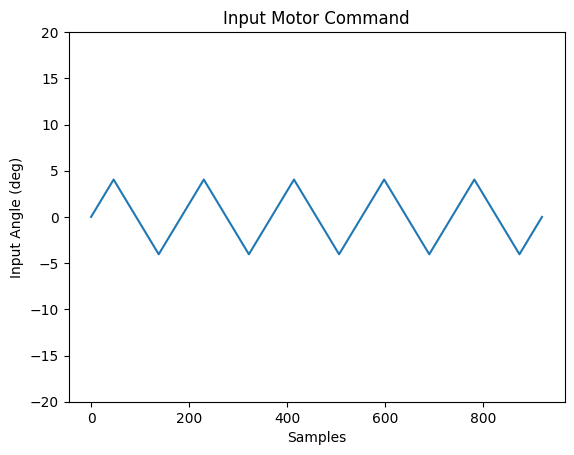

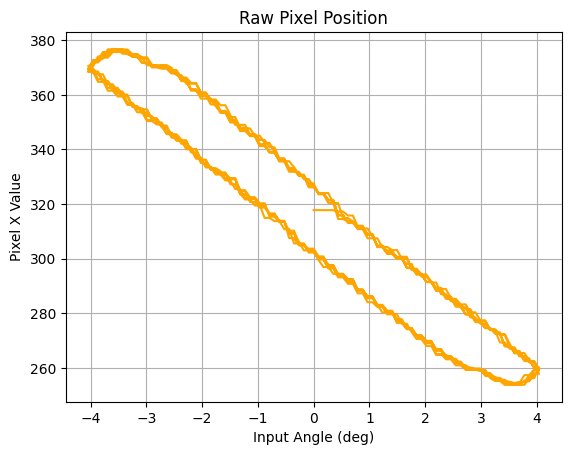

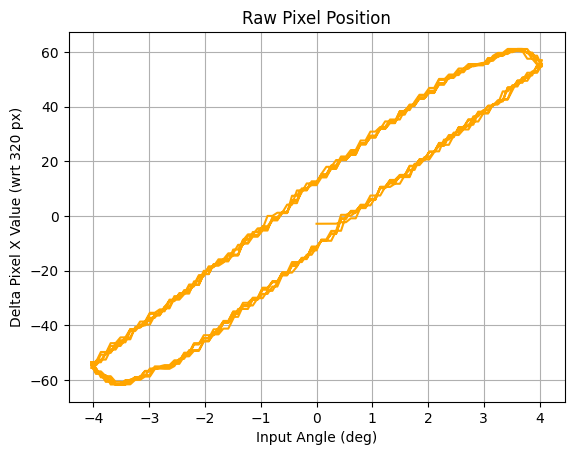

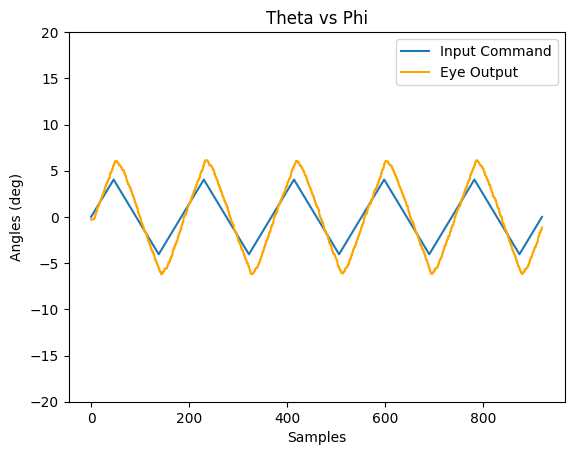

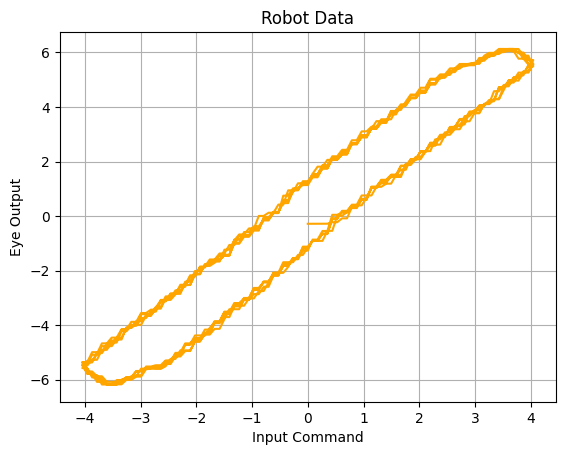

In [30]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=315)

In [29]:
# Appending to Data List

data_list.append(data)

## EXP1.4. 2 Degrees Amplitude

In [32]:
# Parameters

init_amp = 0
min_amp = -2
max_amp = 2
step_size = 0.0879
num_cycles = 5
include_init = 1
time_interval = 0.015  # sec

tilt_arr = [0]

In [33]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep
    "input_arr": [],  # Data points or Triangle Wave
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[ 0.      0.0879  0.1758  0.2637  0.3516  0.4395  0.5274  0.6153  0.7032
  0.7911  0.879   0.9669  1.0548  1.1427  1.2306  1.3185  1.4064  1.4943
  1.5822  1.6701  1.758   1.8459  1.9338  2.0217  1.9338  1.8459  1.758
  1.6701  1.5822  1.4943  1.4064  1.3185  1.2306  1.1427  1.0548  0.9669
  0.879   0.7911  0.7032  0.6153  0.5274  0.4395  0.3516  0.2637  0.1758
  0.0879  0.     -0.0879 -0.1758 -0.2637 -0.3516 -0.4395 -0.5274 -0.6153
 -0.7032 -0.7911 -0.879  -0.9669 -1.0548 -1.1427 -1.2306 -1.3185 -1.4064
 -1.4943 -1.5822 -1.6701 -1.758  -1.8459 -1.9338 -2.0217 -1.9338 -1.8459
 -1.758  -1.6701 -1.5822 -1.4943 -1.4064 -1.3185 -1.2306 -1.1427 -1.0548
 -0.9669 -0.879  -0.7911 -0.7032 -0.6153 -0.5274 -0.4395 -0.3516 -0.2637
 -0.1758 -0.0879  0.      0.0879  0.1758  0.2637  0.3516  0.4395  0.5274
  0.6153  0.7032  0.7911  0.879   0.9669  1.0548  1.1427  1.2306  1.3185
  1.4064  1.4943  1.5822  1.6701  1.758   1.8459  1.9338  2.0217  1.9338
  1.8459  1.758   1.6701  1.5822  1.4943  1.4064  1.

Text(0, 0.5, 'Input Angle (deg)')

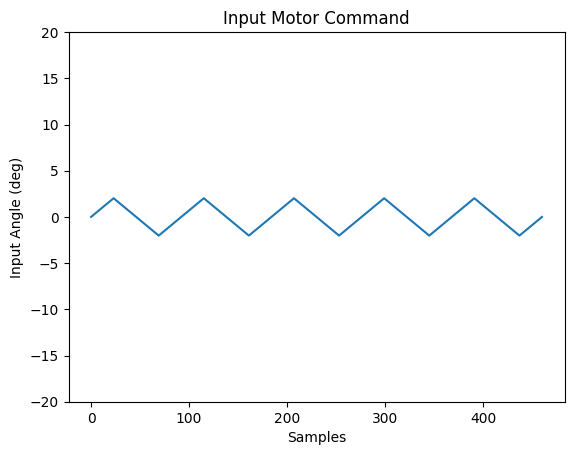

In [34]:
# Generation of triangle wave

input_arr = generate_triangle_wave(init_amp, min_amp, max_amp, step_size, num_cycles, include_init)
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr)
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [35]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr.tolist()

start = time.time()

# Initial State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

cnt = 0
for tilt in tilt_arr:
    pixel_arr = []
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)
        time.sleep(time_interval)
        grace.direct_move_left_eye((pan, None))
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    data["pixel_arr"].append(pixel_arr)

# End State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame)) 
    
print("Elapsed Time:", time.time()-start)

461/461
pan:0.0, tilt:0
Elapsed Time: 26.682151079177856


In [36]:
# Checking of Data

data["pixel_arr"]

[[[318.4018859863281, 203.40875244140625],
  [318.3812255859375, 203.39720153808594],
  [318.3812255859375, 203.39720153808594],
  [318.40374755859375, 203.4049530029297],
  [318.40374755859375, 203.4049530029297],
  [318.40374755859375, 203.4049530029297],
  [318.1333923339844, 203.4805450439453],
  [318.1333923339844, 203.4805450439453],
  [316.4228820800781, 203.7296142578125],
  [316.4228820800781, 203.7296142578125],
  [311.5087585449219, 203.7320556640625],
  [311.5087585449219, 203.7320556640625],
  [308.62127685546875, 203.68344116210938],
  [304.8074951171875, 203.64077758789062],
  [304.8074951171875, 203.64077758789062],
  [304.8074951171875, 203.64077758789062],
  [302.1067810058594, 203.6174774169922],
  [302.1067810058594, 203.6174774169922],
  [300.121826171875, 203.56642150878906],
  [300.121826171875, 203.56642150878906],
  [297.11944580078125, 203.53335571289062],
  [297.11944580078125, 203.53335571289062],
  [293.3027648925781, 203.49371337890625],
  [293.30276489257

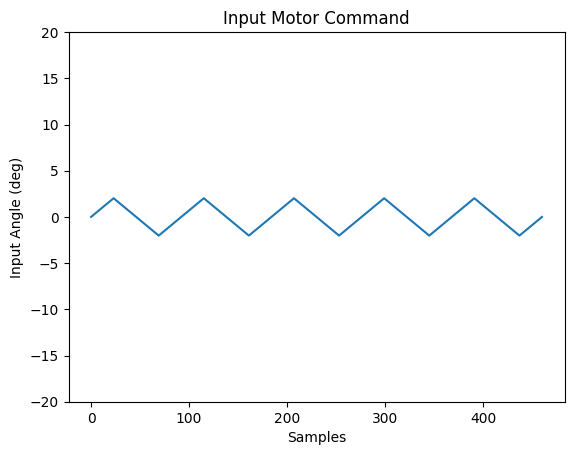

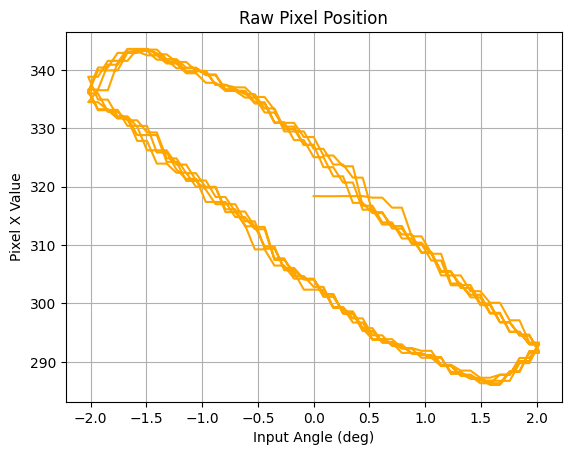

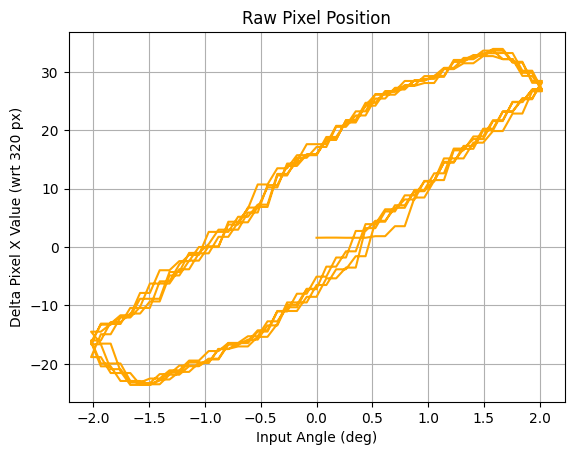

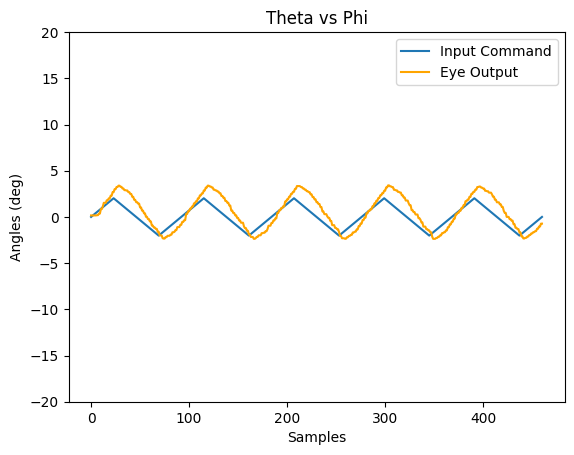

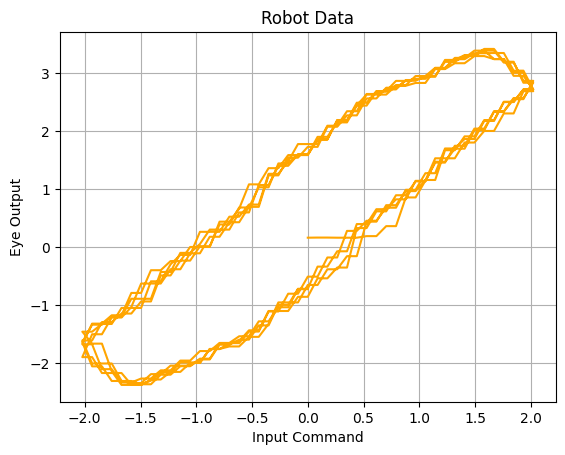

In [37]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=320)

In [38]:
# Appending to Data List

data_list.append(data)

# Saving the Data

In [40]:
pickle_data["data"] = data_list
data_filepath = save_pickle_data(pickle_data, camera="left", name="1D-BASELINE_EXP1_RobotBaseline")

Data saved in: C:\dev\robot_control\const_results\20230530_000517_535176_left_1D-BASELINE_EXP1_RobotBaseline.pickle


# Loading the Data

In [41]:
# Opening of Pickle File

with open(data_filepath, 'rb') as file:
    data_load = pickle.load(file)

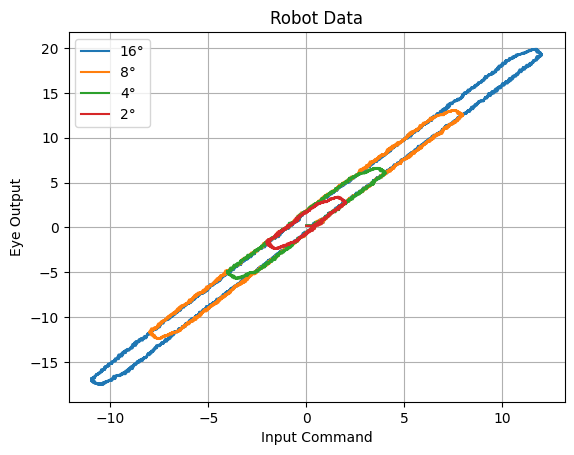

In [42]:
# Data Superposition

# Time Series Eye Output vs Input Array
x_org = 320
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi)
    
plt.xlabel('Input Command')
plt.ylabel('Eye Output')
plt.title('Robot Data')
plt.grid()
plt.legend(["16°", "8°", "4°", "2°"])